created 9-10-24\
manually calculate processes that are in water mass budget

In [1]:
import xarray as xr
import xwmb
import xwmt
import xbudget
import xgcm
from xgcm import Grid
import numpy as np
import warnings
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import cmocean.cm as cmo
import cmocean
import pandas as pd
import dask.array as da
import dask.dataframe as dd
import regionate

# %matplotlib inline
# import CM4Xutils
plt.rcParams['figure.figsize']=(8,5)

In [2]:
cm4x = xr.open_zarr("/pub/kailau/9-26_relevant_yrs/CM4Xp25_2010-2014.zarr",decode_times=False).chunk({"time":-1, "time_bounds":-1})
cm4x = cm4x.fillna(0.)

In [3]:
# cm4x = xr.open_zarr("/pub/kailau/budget_diagnostics/CM4Xp25_budgets_sigma2_2010-2014.zarr",
#                    decode_times=False).chunk({"time":-1, "time_bounds":-1},)

In [4]:
# sigma2_i_use = xr.DataArray(
#     np.concatenate([np.array([0]), (cm4x.sigma2_l.values[1:] + cm4x.sigma2_l.values[:-1])/2, np.array([50])]),
#     dims=("sigma2_i",)
# )

In [5]:
# set up a grid
# cm4x = cm4x.assign_coords(sigma2_i = sigma2_i_use)

coords = {'X':{'center':'xh','outer':'xq'},
          'Y':{'center':'yh','outer':'yq'},
          'Z':{'center':'sigma2_l','outer':'sigma2_i'}}
metrics = {('X','Y'):'areacello'}
grid = Grid(cm4x,coords=coords, boundary ={'X':'periodic','Y':'extend','Z':'extend'}, metrics=metrics,autoparse_metadata=False)

10-10-24
### Make a mask
The domain (for vmo(yq,xh)) is (0-90, 0-119) \
The domain (for umo(yh,xq)) is (0-89, 0-120)

<font color='hotpink'> Baby region </font> \
So then we can define the domain R, for all densities, to be the region below the equator (`cm4x.where(cm4x.yq<0`) \ 
Why is this not a normal rectangle? For the bermuda triangle, the resolution also looks really blocky and off? Is it just because it's coarse? but even so, for a rectangle, why aren't the lines just straight?

In [ ]:
# name='baby_region'
# # lons = np.array([8.,   29., 24.5, 24.5, 26.1, 17.5, 11.5])
# # lats = np.array([53.5, 54.5,  59.,  61.,  63., 64.5,  62.])

# lons = np.array([0., 0., 119., 119.])
# lats = np.array([0., 40., 40., 0.])

# # lons, lats = np.array([-80., -66., -65.]), np.array([ 26.,  18.,  32.])
# region = regionate.GriddedRegion(name,lons,lats,grid)
# plt.plot(regionate.loop(region.lons),regionate.loop(region.lats))

In [7]:
# # define region 
# # Baby region... lower 1/2 of latitude domain (below what I'm assuming... is the equator) or 40-N?
# region = cm4x.where(cm4x.yq<40)#.fillna(0.)
# region.vmo.isel(exp=0,sigma2_l=-2).mean(dim='time').plot()

# # why don't the region & the cm4x stuff have the same values in the southern lats of the domain? based on the region, I thought they would look similar.
# region.vmo.isel(exp=0,time=30,sigma2_l=4).plot()
# cm4x.vmo.isel(exp=0,time=30,sigma2_l=4).plot()

## ???

I think I need to make a mask

/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_t

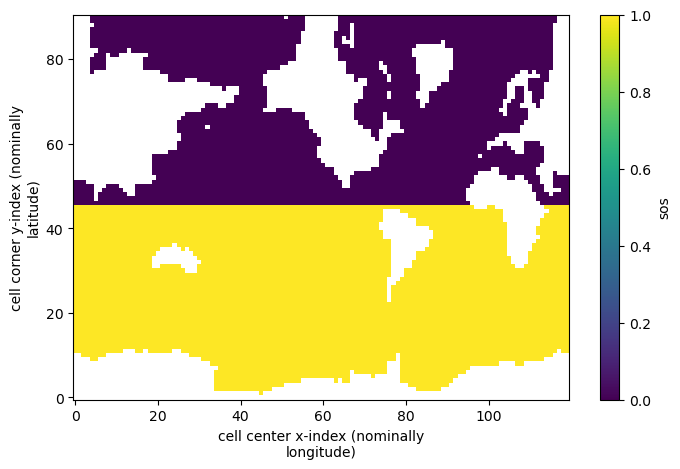

/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/homezvol3/kailau/.conda/envs/environment/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [8]:
# choosing sos because it uses the yh/xh coordinates?? do the coordinates with vmo HAVE to align though? sos also preserves the land
# interpolate sos to be on yq points to match vmo
sos_interp = grid.interp(cm4x.sos.isel(exp=0,time=30),axis='Y')
chosen_region = sos_interp.isel(yq=slice(0,46))
ones = chosen_region / chosen_region
# ones.plot()

# masked area to leave as zeros
exclude = sos_interp.isel(yq=slice(46,91))
zeros = (exclude / exclude) -1
# zeros.plot()

# combine ones and zeros plots to make a "mask" that can be multiplied by the full region, isolating just the values that fall within the chosen region R
full = xr.merge([ones,zeros])
full.sos.plot()

mask = full.sos

# # interpolate the sos to be on yq points to match vmo
# mask = grid.interp(mask,axis='Y')
# mask
# mask.plot()

In [9]:
full.sos

<xarray.DataArray 'sos' (yq: 91, xh: 120)> Size: 44kB
dask.array<where, shape=(91, 120), dtype=float32, chunksize=(91, 120), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) int64 960B 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
  * yq       (yq) int64 728B 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90

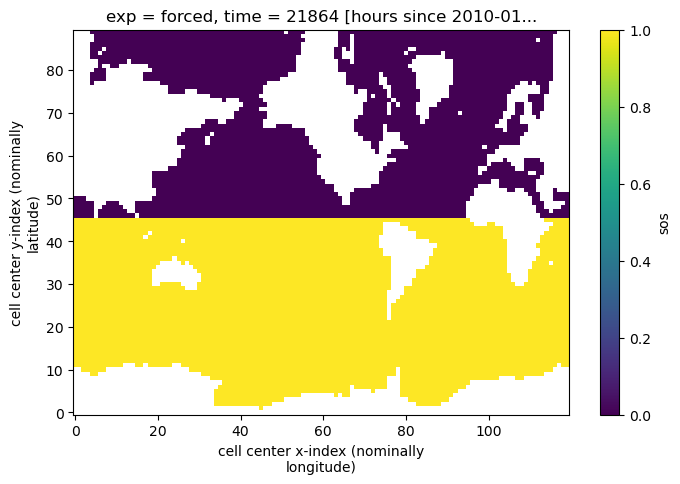

In [10]:
# for uninterpolated coordinates (to be on (yh,xh))... for mass_tendency
yhxh_region = cm4x.sos.isel(exp=0,time=30,yh=slice(0,46))
yhxh_ones = yhxh_region / yhxh_region
# yhxh_ones.plot()

# masked area to leave as zeros
yhxh_exclude = cm4x.sos.isel(exp=0,time=30,yh=slice(46,91))
yhxh_zeros = (yhxh_exclude /yhxh_exclude) -1
# yhxh_zeros.plot()

# combine ones and zeros to make a "mask" that can be multiplied by the full region, isolating just the values that fall within the chosen region R
yhxh_full = xr.merge([yhxh_ones,yhxh_zeros])
# yhxh_full.sos.plot()

yhxh_mask = yhxh_full.sos
yhxh_mask.plot()

## changing the potential density from 37.1 to 35 just so we can get *something* that isn't zeros because idk, there isn't much data for potential density values greater than 37.1
### mass tendency
vmo is ocean mass Y transport measured in kg/s. Is this... not already tendency?

In [11]:
boundary_rho = 35

In [12]:
cm4x.sigma2_l

<xarray.DataArray 'sigma2_l' (sigma2_l: 74)> Size: 592B
array([ 4.24625, 13.565  , 17.71   , 21.855  , 25.96375, 28.165  , 28.495  ,
       28.83   , 29.165  , 29.495  , 29.83   , 30.165  , 30.495  , 30.83   ,
       31.165  , 31.495  , 31.83   , 32.165  , 32.495  , 32.83   , 33.0665 ,
       33.28225, 33.571  , 33.8425 , 34.09975, 34.3435 , 34.5735 , 34.7895 ,
       34.991  , 35.17725, 35.348  , 35.5035 , 35.64475, 35.77275, 35.8885 ,
       35.99375, 36.09025, 36.17925, 36.262  , 36.34   , 36.4145 , 36.4865 ,
       36.5565 , 36.625  , 36.692  , 36.75525, 36.812  , 36.86125, 36.904  ,
       36.9415 , 36.974  , 37.002  , 37.02625, 37.0475 , 37.0665 , 37.08375,
       37.1    , 37.116  , 37.132  , 37.148  , 37.164  , 37.18   , 37.1965 ,
       37.2145 , 37.235  , 37.26   , 37.2945 , 37.345  , 37.415  , 37.5075 ,
       37.625  , 37.76   , 37.9    , 38.485  ])
Coordinates:
    rho2_l    (sigma2_l) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
  * sigma2_l  (sigma2_l) float64 592B 4.246 13.57 17.71 ... 37.76 37.9 38.49
Attributes:
    axis:          Z
    cell_methods:  sigma2_l:point
    edges:         sigma2_i
    long_name:     Target Potential Density minus 1000 kg/m3 at cell center
    positive:      down
    units:         kg m-3

In [13]:
cm4x.xq

<xarray.DataArray 'xq' (xq: 121)> Size: 968B
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120])
Coordinates:
  * xq       (xq) int64 968B 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119 120
Attributes:
    cell_methods:  xq:point
    long_name:     cell corner x-index (nominally longitude)

In [14]:
cm4x.areacello

<xarray.DataArray 'areacello' (yh: 90, xh: 120)> Size: 43kB
dask.array<open_dataset-areacello, shape=(90, 120), dtype=float32, chunksize=(90, 120), chunktype=numpy.ndarray>
Coordinates:
    areacello  (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho     (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    geolat     (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    geolon     (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lat        (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lon        (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    wet        (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * xh         (xh) int64 960B 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * yh         (yh) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
Attributes:
    cell_methods:   area:sum yh:sum xh:sum time: point
    long_name:      Ocean Grid-Cell Area
    standard_name:  cell_area
    units:          m2

In [15]:
cm4x.dyCu

<xarray.DataArray 'dyCu' (yh: 90, xq: 121)> Size: 44kB
dask.array<open_dataset-dyCu, shape=(90, 121), dtype=float32, chunksize=(90, 121), chunktype=numpy.ndarray>
Coordinates:
    dyCu      (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolat_u  (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolon_u  (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    wet_u     (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * xq        (xq) int64 968B 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
  * yh        (yh) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
Attributes:
    cell_methods:   xq:point yh:sum time:point
    interp_method:  none
    long_name:      Delta(y) at u points (meter)
    units:          m

In [16]:
cm4x.sigma2_l / cm4x.dxCv

<xarray.DataArray (sigma2_l: 74, yq: 91, xh: 120)> Size: 6MB
dask.array<divide, shape=(74, 91, 120), dtype=float64, chunksize=(74, 91, 120), chunktype=numpy.ndarray>
Coordinates:
    rho2_l    (sigma2_l) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
  * sigma2_l  (sigma2_l) float64 592B 4.246 13.57 17.71 ... 37.76 37.9 38.49
    dxCv      (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    geolat_v  (yq, xh) float64 87kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    geolon_v  (yq, xh) float64 87kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    wet_v     (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
  * xh        (xh) int64 960B 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * yq        (yq) int64 728B 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90

In [17]:
cm4x

<xarray.Dataset> Size: 11GB
Dimensions:                         (exp: 2, time: 60, sigma2_l: 74, yh: 90,
                                     xh: 120, time_bounds: 61, xq: 121, yq: 91,
                                     sigma2_i: 75)
Coordinates: (12/30)
    areacello                       (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho                          (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    dxCv                            (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    dyCu                            (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * exp                             (exp) object 16B 'forced' 'control'
    geolat                          (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...                              ...
    wet_u                           (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    wet_v                           (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
  * xh                              (xh) int64 960B 0 1 2 3 ... 116 117 118 119
  * xq                              (xq) int64 968B 0 1 2 3 ... 117 118 119 120
  * yh                              (yh) int64 720B 0 1 2 3 4 ... 85 86 87 88 89
  * yq                              (yq) int64 728B 0 1 2 3 4 ... 86 87 88 89 90
Data variables: (12/29)
    S_advection_xy                  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    Sh_tendency_vert_remap          (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    T_advection_xy                  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    Th_tendency_vert_remap          (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    boundary_forcing_h_tendency     (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    boundary_forcing_heat_tendency  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    ...                              ...
    thkcello                        (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    thkcello_bounds                 (exp, time_bounds, sigma2_l, yh, xh) float32 390MB dask.array<chunksize=(2, 61, 74, 90, 120), meta=np.ndarray>
    tos                             (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    umo                             (exp, time, sigma2_l, yh, xq) float32 387MB dask.array<chunksize=(2, 60, 74, 90, 121), meta=np.ndarray>
    vert_remap_h_tendency           (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    vmo                             (exp, time, sigma2_l, yq, xh) float32 388MB dask.array<chunksize=(2, 60, 74, 91, 120), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 20100101.ocean_static.nc
    description:         The CM4Xp25 experimental design following Griffies e...
    external_variables:  volcello areacello
    filename:            ocean_monthly_z.201001-201412.S_advection_xy.nc
    grid_tile:           N/A
    grid_type:           regular
    model:               CM4Xp25
    provenance:          Diagnostics have been conservatively remapped into m...
    title:               CM4_historical_c192_OM4p25

In [18]:
cm4x.sigma2_i / cm4x.dyCu

<xarray.DataArray (sigma2_i: 75, yh: 90, xq: 121)> Size: 7MB
dask.array<divide, shape=(75, 90, 121), dtype=float64, chunksize=(75, 90, 121), chunktype=numpy.ndarray>
Coordinates:
    rho2_i    (sigma2_i) float64 600B dask.array<chunksize=(75,), meta=np.ndarray>
  * sigma2_i  (sigma2_i) float64 600B -3.0 11.49 15.64 ... 37.83 37.97 39.0
    dyCu      (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolat_u  (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolon_u  (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    wet_u     (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * xq        (xq) int64 968B 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
  * yh        (yh) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89

In [19]:
# rho = mass / volume ==> mass = rho * volume
# PAY ATTENTION TO THIS... DOES EITHER WAY WORK. ONE (ISEL) JUST ELIMINATES THE UNUSED COORDINATES
watermass = cm4x.where(cm4x.sigma2_l > boundary_rho) 
# watermass = cm4x.isel(sigma2_l=slice(57,74))
wmv = watermass.areacello * watermass.thkcello * 10**(-6)# <-- volume (Sv * seconds)
wmv = wmv.dropna('sigma2_l',how='all')

# assuming no mask, otherwise, multiply by mask
# mask is on (yq,xh) coordinates (to match vmo), so you have to interpolate along y-axis to 
massftime = (watermass.sigma2_l * wmv * yhxh_mask).sum(dim = ['xh','yh','sigma2_l'])

dmass = massftime.isel(exp=0).diff('time')
dtime = massftime.time.diff('time')

# mass tendency 
mass_tendency = dmass / dtime
mass_tendency

<xarray.DataArray (time: 59)> Size: 472B
dask.array<truediv, shape=(59,), dtype=float64, chunksize=(59,), chunktype=numpy.ndarray>
Coordinates:
    exp      <U6 24B 'forced'
  * time     (time) int64 472B 708 1416 2148 2880 ... 40860 41592 42324 43056

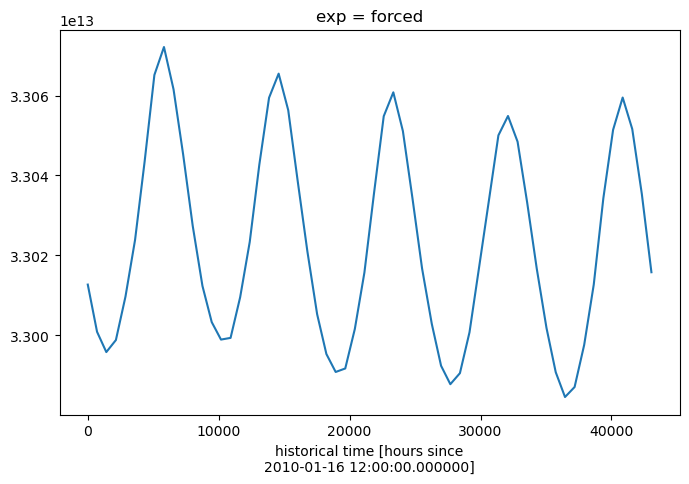

In [20]:
massftime.isel(exp=0).plot()

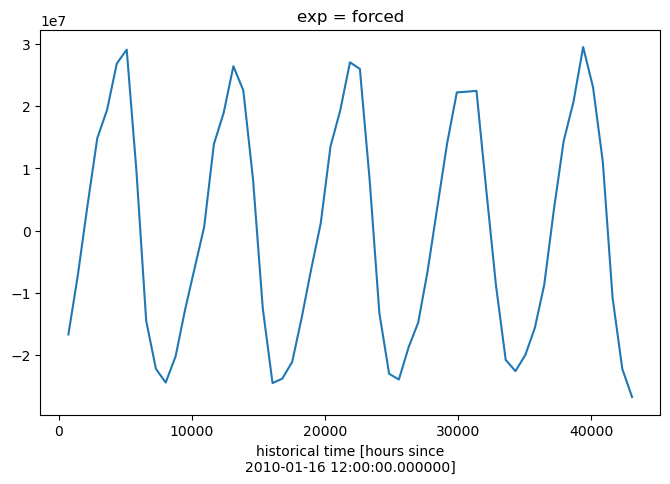

In [21]:
mass_tendency.plot()

## Define a boundary

In [22]:
# we want the transport ONLY at the boundary, which we have established to be at 45N (based on definition of mask)
mask_lat =  45 # mass_tendency uses yq lats
boundary = watermass.isel(exp=0,yq=mask_lat)

## diascalar overturning ($\Psi$)
The streamfunction is for water moving in and out of the region that we defined. So, like, we define a watermass to be any water with a density greater than 37.1 Cool. Say that this is the entire bottom of the ocean. Now define a region R (separate from that water mass) to be any part of the domain that is below the equator. Cool. Now we want to look at the intersection of the water mass and the region. Therefore, not all of the water mass is in the region, so water can still move in & out of the region without any "transformation" occurring. This water must be accounted for. We can use a streamfunction to do so where we integrate vertically over the boundary of the intersection to get the amount of water moving in and out of the region and the water mass. 

$
\Psi = \displaystyle\int_{x}\ \displaystyle\int_{z=-H}^{z_{\sigma_2=37.1}} \vec{v} \, dz \, dx 
$

> - We have mass in the form of `vmo` (ocean mass y transport measured in kg/s)
> - We want velocity (measured in m/s)
> - $\sigma_2$ is density (measured in kg/m$^{2}$)
> - the volume of a area of the surface the meridional velocity travels through is equal to `dxCv` $\times$ `thkcello` $=$ (x-y area) $\times$ height
> - so to get from vmo to meridional velocity:

\begin{align}
\text{velocity} &= \frac{\text{vmo}}{\sigma_{2_l}} \times \frac{1}{\text{dxCv}} \times \frac{1}{\text{thkcello}} \\
\frac{\text{m}}{\text{s}} &= \frac{\text{kg}}{\text{s}} \times \frac{\text{m$^3$}}{\text{kg}} \times \frac{\text{1}}{\text{m}} \times \frac{\text{1}}{\text{m}}
\end{align}


\begin{align}
\text{velocity} &= \frac{\text{vmo}}{\sigma_2} * \frac{1}{dx} * \frac{1}{dz} \\
\implies \frac{\text{vmo}}{\sigma_2} & = \text{velocity} * dx * dz \\
\implies \Psi &= \int_x \displaystyle\int_{z=-H}^{z_{\sigma_2=boundaryrho}} \frac{\text{vmo}}{\sigma_2} 
\end{align}

Therefore, when we calculate the streamfunction for transport, we do not need to multiple `vmo` by `dxCv` or `thkcello` because they are already included in the calculation of `vmo`.


In [23]:
'''
cm4x.vmo.where(cm4x.vmo > 0).isel(exp=0).mean(dim='time').dropna('sigma2_l',how='all').sel(yq=45,method='nearest').plot()
plt.gca().invert_yaxis()
'''

"\ncm4x.vmo.where(cm4x.vmo > 0).isel(exp=0).mean(dim='time').dropna('sigma2_l',how='all').sel(yq=45,method='nearest').plot()\nplt.gca().invert_yaxis()\n"

In [24]:
'''
nonzerovmo = cm4x.vmo.where(cm4x.vmo > 0).isel(exp=0).mean(dim='time').dropna('sigma2_l',how='all').sel(yq=45,method='nearest')
bottom = nonzerovmo.where(nonzerovmo.sigma2_l > boundary_rho)# .dropna('sigma2_l',how='all')
bottom.plot()
plt.gca().invert_yaxis()
'''

"\nnonzerovmo = cm4x.vmo.where(cm4x.vmo > 0).isel(exp=0).mean(dim='time').dropna('sigma2_l',how='all').sel(yq=45,method='nearest')\nbottom = nonzerovmo.where(nonzerovmo.sigma2_l > boundary_rho)# .dropna('sigma2_l',how='all')\nbottom.plot()\nplt.gca().invert_yaxis()\n"

In [25]:
'''
# get thkcello on yh instead of yq
interp_thkcello = grid.interp(boundary.thkcello, axis='Y')
#interp_thkcello

velo = (boundary.vmo / (boundary.sigma2_l + 1000)) * boundary.dxCv * boundary.thkcello
boundary_velo = velo.sel(yh=45,method='nearest').mean(dim='time')

# restrict only to water mass
wm_boundary_vvel = boundary_velo.where(boundary_velo.sigma2_l > boundary_rho).dropna('sigma2_l',how='all')
'''

"\n# get thkcello on yh instead of yq\ninterp_thkcello = grid.interp(boundary.thkcello, axis='Y')\n#interp_thkcello\n\nvelo = (boundary.vmo / (boundary.sigma2_l + 1000)) * boundary.dxCv * boundary.thkcello\nboundary_velo = velo.sel(yh=45,method='nearest').mean(dim='time')\n\n# restrict only to water mass\nwm_boundary_vvel = boundary_velo.where(boundary_velo.sigma2_l > boundary_rho).dropna('sigma2_l',how='all')\n"

In [26]:
# wm_boundary_vvel.plot()

# I think we can just use `vmo`, we don't need to actually calculate velocity

does it make sense to plot it like this? like as an actual streamfunction? I guess we're not averaging over latitude; we're just selecting one specific latitude...

In [27]:
meanbvmo = boundary.vmo.mean(dim='time')
wm_boundary_vmo = meanbvmo.where(meanbvmo.sigma2_l > boundary_rho).dropna('sigma2_l',how='all')
wm_boundary_vmo
vmo_intx = (-wm_boundary_vmo * 10**(-6)/ (boundary.sigma2_l+1035)).sum('xh') #.cumsum('sigma2_l')
psimaybe = (vmo_intx[::-1]).cumsum('sigma2_l')
psimaybe

<xarray.DataArray (sigma2_l: 45)> Size: 360B
dask.array<nancumsum, shape=(45,), dtype=float64, chunksize=(45,), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_l  (sigma2_l) float64 360B 38.49 37.9 37.76 ... 35.5 35.35 35.18
    exp       <U6 24B 'forced'
    rho2_l    (sigma2_l) float64 360B dask.array<chunksize=(45,), meta=np.ndarray>
    yq        int64 8B 45

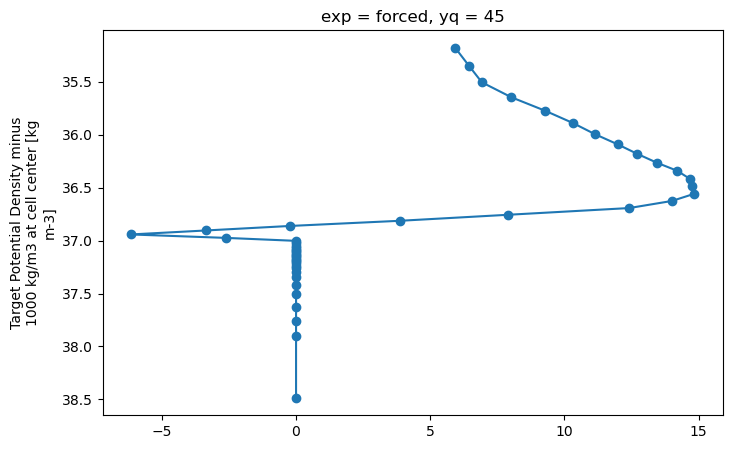

In [28]:
fig,ax = plt.subplots(nrows=1,ncols=1)
psimaybe.plot(y='sigma2_l',marker='o')
ax.invert_yaxis()

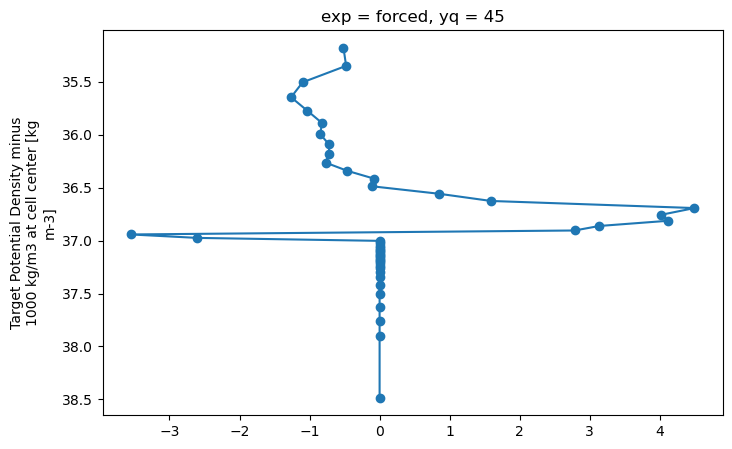

In [29]:
fig,ax = plt.subplots(nrows=1,ncols=1)
vmo_intx.plot(y='sigma2_l',marker='o')
ax.invert_yaxis()

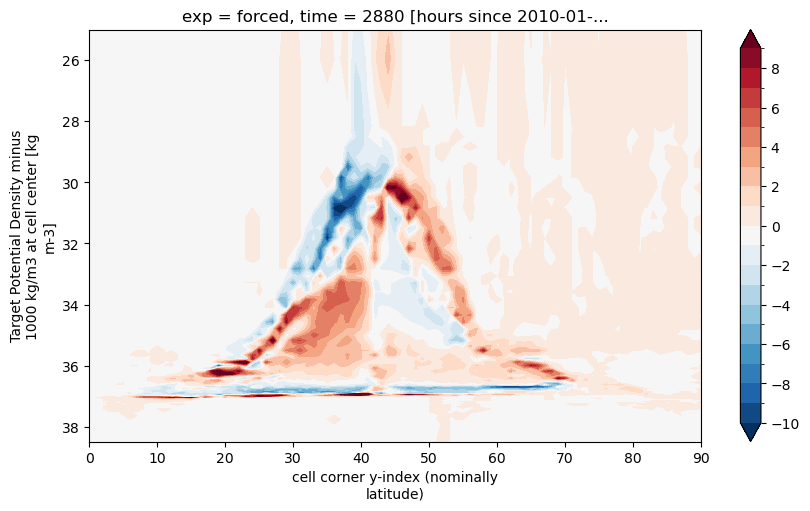

In [30]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
cm4x_cut = cm4x.isel(exp=0,time=4)
cm4xpsimaybe = (cm4x_cut.vmo * 10**(-6) / (cm4x_cut.sigma2_l + 1035)).sum('xh')
clevels = np.arange(-10,10,1)
cm4xpsimaybe.plot.contourf(levels=clevels)
ax.set_ylim(25,cm4xpsimaybe.sigma2_l.max())
ax.invert_yaxis()

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/kailau/34753598/ipykernel_34912/519263582.py:6: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('$0^\circ$N Meridional Transport \n $\sigma_2$ > ' +str(boundary_rho))


Text(0.5, 1.0, '$0^\\circ$N Meridional Transport \n $\\sigma_2$ > 35')

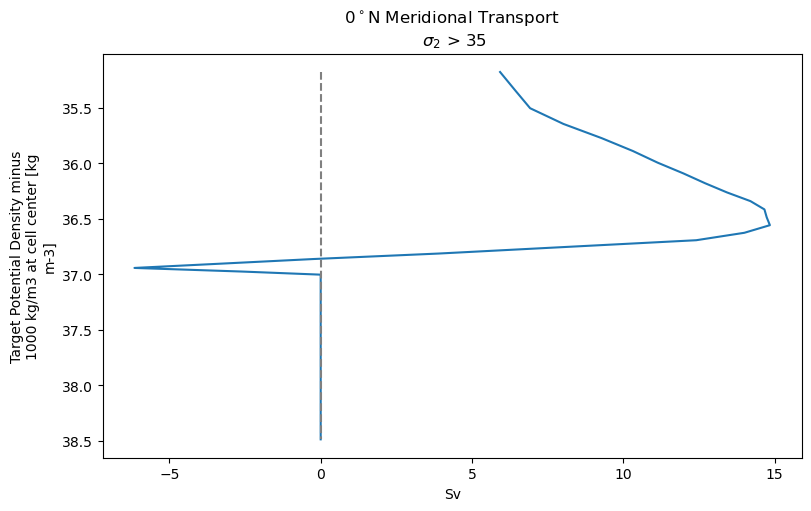

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
psimaybe.plot(y='sigma2_l')
ax.vlines(x=0,ymin=psimaybe.sigma2_l.min(),ymax=psimaybe.sigma2_l.max(),linestyle='--',color='gray')
ax.invert_yaxis()
ax.set_xlabel('Sv')
ax.set_title('$0^\circ$N Meridional Transport \n $\sigma_2$ > ' +str(boundary_rho))

# Sv > 0 means water is getting denser; Sv < 0 means water is getting lighter (more out of isopycnal than in)

# Surface Flux

Net surface mass flux into the water mass: 

$
S_{\leq} (\widetilde \lambda,t) = - \int_{\partial \Omega_{surf}(\widetilde \lambda,t)} \, \rho(\vec{v} - \vec{v}^{(s)}) \cdot \hat{n}^{(s)} \, dS = \int_{\partial \Omega_{surf}(\widetilde \lambda,t)} \mathcal{Q}_M^{surf} \,dS
$ 

But we can use the horizontal projection of the surface $dS$, called $dA$. So then 

$Q_M^{surf} \equiv \mathcal{Q}_M^{surf} dS/dA$

So then if we have a horizontally flat surface, then the normal vector would be $\left \langle 0,1 \right \rangle$?

In which case, 

*you are literally just saying that the change in water mass due to surface fluxes is equal to the increase or decrease in volume of the grid cell* \
*and then you calculate volume by multiplying the area by the forcing tendency*\
***but then isn't boundary forcing part of D? Not S?***
>- check how boundary forcing is defined somewhere

In [32]:
htend = watermass.boundary_forcing_h_tendency.isel(exp=0)
htend_all = htend.where(htend.sigma2_l > boundary_rho).dropna('sigma2_l',how='all')

In [33]:
area = htend_all.areacello 
S = (area * htend_all * (htend_all.sigma2_l+1035) / (10**6)).mean(dim='time')
S_ds = S.to_dataset(name='mass_surface_flux')
S_ds

<xarray.Dataset> Size: 4MB
Dimensions:            (yh: 90, xh: 120, sigma2_l: 45)
Coordinates:
    areacello          (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho             (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    exp                <U6 24B 'forced'
    geolat             (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    geolon             (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lat                (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lon                (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    wet                (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * xh                 (xh) int64 960B 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
  * yh                 (yh) int64 720B 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
    rho2_l             (sigma2_l) float64 360B dask.array<chunksize=(45,), meta=np.ndarray>
  * sigma2_l           (sigma2_l) float64 360B 35.18 35.35 35.5 ... 37.9 38.49
Data variables:
    mass_surface_flux  (yh, xh, sigma2_l) float64 4MB dask.array<chunksize=(90, 120, 45), meta=np.ndarray>

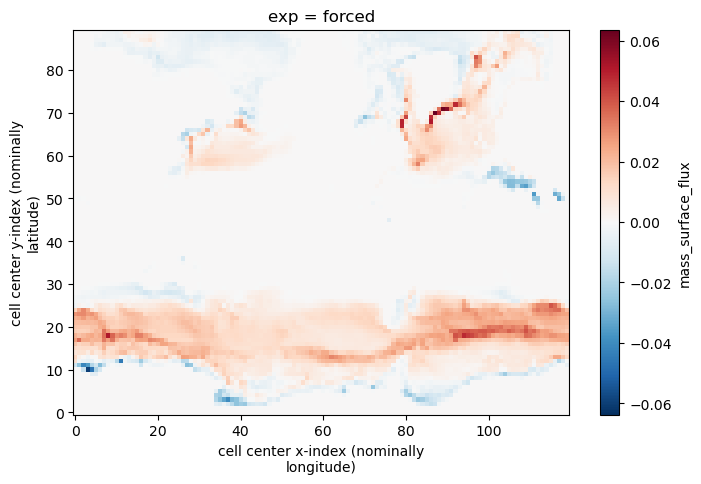

In [34]:
mass_surface_flux_same_lev = S_ds.mass_surface_flux.mean(dim='sigma2_l')
mass_surface_flux_same_lev.plot()

In [35]:
# mass_surface_flux_same_lev = S_ds.mass_surface_flux.sum(dim='sigma2_l')
# mass_surface_flux_same_lev.plot()

# Diapycnal Transport???
$ 
D_{\leq} \equiv - \int_{\mathcal{A_R}(\widetilde \lambda,t)} \, \rho(\vec{v} - \vec{v}^{(\widetilde \lambda)}) \cdot \hat{n}^{(\widetilde \lambda)} \, \text{d}S 
$
you need to redefine your watermass density boundaries because right now, you are calculating for all densities *below* the `boundary_rho` density, so you can't find the amount of water leaving the watermass to enter higher density classes (there are no higher density classes).

so for this calculation, I guess, redefine the watermass to be the water at densities less than `boundary_rho` instead of greater than... Until you fix this.

## calculate the first term
$
\int_{\mathcal{A_R}(\widetilde \lambda,t)} \, (\rho \vec{v} \cdot \hat{n}^{(\widetilde \lambda)}) \, \text{d}S 
$

In [36]:
cm4x.sigma2_l

<xarray.DataArray 'sigma2_l' (sigma2_l: 74)> Size: 592B
array([ 4.24625, 13.565  , 17.71   , 21.855  , 25.96375, 28.165  , 28.495  ,
       28.83   , 29.165  , 29.495  , 29.83   , 30.165  , 30.495  , 30.83   ,
       31.165  , 31.495  , 31.83   , 32.165  , 32.495  , 32.83   , 33.0665 ,
       33.28225, 33.571  , 33.8425 , 34.09975, 34.3435 , 34.5735 , 34.7895 ,
       34.991  , 35.17725, 35.348  , 35.5035 , 35.64475, 35.77275, 35.8885 ,
       35.99375, 36.09025, 36.17925, 36.262  , 36.34   , 36.4145 , 36.4865 ,
       36.5565 , 36.625  , 36.692  , 36.75525, 36.812  , 36.86125, 36.904  ,
       36.9415 , 36.974  , 37.002  , 37.02625, 37.0475 , 37.0665 , 37.08375,
       37.1    , 37.116  , 37.132  , 37.148  , 37.164  , 37.18   , 37.1965 ,
       37.2145 , 37.235  , 37.26   , 37.2945 , 37.345  , 37.415  , 37.5075 ,
       37.625  , 37.76   , 37.9    , 38.485  ])
Coordinates:
    rho2_l    (sigma2_l) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
  * sigma2_l  (sigma2_l) float64 592B 4.246 13.57 17.71 ... 37.76 37.9 38.49
Attributes:
    axis:          Z
    cell_methods:  sigma2_l:point
    edges:         sigma2_i
    long_name:     Target Potential Density minus 1000 kg/m3 at cell center
    positive:      down
    units:         kg m-3

In [37]:
# we need the normal vector to the bounding surface between the water mass and higher densities
# do we not need to think about the bounding surface above? 

# redefine water mass to be densities less than the boundary_rho instead of greater than
# find sigma2_l indices for slicing water mass
watermass.sigma2_l.where(watermass.sigma2_l < boundary_rho).dropna('sigma2_l',how='all')

boundary_layer_index = len(watermass.sigma2_l.where(watermass.sigma2_l < boundary_rho).dropna('sigma2_l',how='all'))


boundary_layer = watermass.isel(exp=0,sigma2_l=boundary_layer_index)
boundary_layer.boundary_forcing_h_tendency

<xarray.DataArray 'boundary_forcing_h_tendency' (time: 60, yh: 90, xh: 120)> Size: 3MB
dask.array<getitem, shape=(60, 90, 120), dtype=float32, chunksize=(60, 90, 120), chunktype=numpy.ndarray>
Coordinates: (12/14)
    areacello        (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho           (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    exp              <U6 24B 'forced'
    geolat           (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    geolon           (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lat              (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...               ...
    sigma2_l         float64 8B 35.18
  * time             (time) int64 480B 0 708 1416 2148 ... 41592 42324 43056
    time_since_init  (time) int64 480B dask.array<chunksize=(60,), meta=np.ndarray>
    wet              (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * xh               (xh) int64 960B 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
  * yh               (yh) int64 720B 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean sigma2_l:sum yh:mean xh:mean time:mean
    long_name:      Cell thickness tendency due to boundary forcing
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m s-1

In [38]:
# calculate rho * velo_vector
rhou, rhov, rhow = boundary_layer.umo, boundary_layer.vmo, boundary_layer.boundary_forcing_h_tendency * (boundary_layer.sigma2_l + 1035) * boundary_layer.areacello


In [39]:
watermass

<xarray.Dataset> Size: 12GB
Dimensions:                         (exp: 2, time: 60, sigma2_l: 74, yh: 90,
                                     xh: 120, time_bounds: 61, xq: 121, yq: 91,
                                     sigma2_i: 75)
Coordinates: (12/30)
    areacello                       (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho                          (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    dxCv                            (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    dyCu                            (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * exp                             (exp) object 16B 'forced' 'control'
    geolat                          (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...                              ...
    wet_u                           (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    wet_v                           (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
  * xh                              (xh) int64 960B 0 1 2 3 ... 116 117 118 119
  * xq                              (xq) int64 968B 0 1 2 3 ... 117 118 119 120
  * yh                              (yh) int64 720B 0 1 2 3 4 ... 85 86 87 88 89
  * yq                              (yq) int64 728B 0 1 2 3 4 ... 86 87 88 89 90
Data variables: (12/29)
    S_advection_xy                  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    Sh_tendency_vert_remap          (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    T_advection_xy                  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    Th_tendency_vert_remap          (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    boundary_forcing_h_tendency     (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    boundary_forcing_heat_tendency  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    ...                              ...
    thkcello                        (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    thkcello_bounds                 (exp, time_bounds, sigma2_l, yh, xh) float32 390MB dask.array<chunksize=(2, 61, 74, 90, 120), meta=np.ndarray>
    tos                             (exp, time, yh, xh, sigma2_l) float32 384MB dask.array<chunksize=(2, 60, 90, 120, 74), meta=np.ndarray>
    umo                             (exp, time, sigma2_l, yh, xq) float32 387MB dask.array<chunksize=(2, 60, 74, 90, 121), meta=np.ndarray>
    vert_remap_h_tendency           (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    vmo                             (exp, time, sigma2_l, yq, xh) float32 388MB dask.array<chunksize=(2, 60, 74, 91, 120), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 20100101.ocean_static.nc
    description:         The CM4Xp25 experimental design following Griffies e...
    external_variables:  volcello areacello
    filename:            ocean_monthly_z.201001-201412.S_advection_xy.nc
    grid_tile:           N/A
    grid_type:           regular
    model:               CM4Xp25
    provenance:          Diagnostics have been conservatively remapped into m...
    title:               CM4_historical_c192_OM4p25

In [40]:
watermass.umo.isel(exp=0,time=0,sigma2_l=boundary_layer_index)
watermass.umo.isel(exp=0,time=0,sigma2_l=boundary_layer_index +1)

<xarray.DataArray 'umo' (yh: 90, xq: 121)> Size: 44kB
dask.array<getitem, shape=(90, 121), dtype=float32, chunksize=(90, 121), chunktype=numpy.ndarray>
Coordinates:
    dyCu             (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    exp              <U6 24B 'forced'
    geolat_u         (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolon_u         (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    rho2_l           float64 8B dask.array<chunksize=(), meta=np.ndarray>
    sigma2_l         float64 8B 35.35
    time             int64 8B 0
    time_since_init  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    wet_u            (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * xq               (xq) int64 968B 0 1 2 3 4 5 6 ... 115 116 117 118 119 120
  * yh               (yh) int64 720B 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Attributes:
    cell_methods:   sigma2_l:sum yh:sum xq:point time:mean
    interp_method:  none
    long_name:      Ocean Mass X Transport
    standard_name:  ocean_mass_x_transport
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg s-1

In [41]:
# the w component
drhodz = watermass.isel(exp=0,sigma2_l = boundary_layer_index)

In [42]:
sigma_BLplus1 = watermass.isel(exp=0,sigma2_l = boundary_layer_index+1)
sigma_BLplus1.umo / sigma_BLplus1.umo

<xarray.DataArray 'umo' (time: 60, yh: 90, xq: 121)> Size: 3MB
dask.array<truediv, shape=(60, 90, 121), dtype=float32, chunksize=(60, 90, 121), chunktype=numpy.ndarray>
Coordinates:
    dyCu             (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    exp              <U6 24B 'forced'
    geolat_u         (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolon_u         (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    rho2_l           float64 8B dask.array<chunksize=(), meta=np.ndarray>
    sigma2_l         float64 8B 35.35
  * time             (time) int64 480B 0 708 1416 2148 ... 41592 42324 43056
    time_since_init  (time) int64 480B dask.array<chunksize=(60,), meta=np.ndarray>
    wet_u            (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * xq               (xq) int64 968B 0 1 2 3 4 5 6 ... 115 116 117 118 119 120
  * yh               (yh) int64 720B 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89

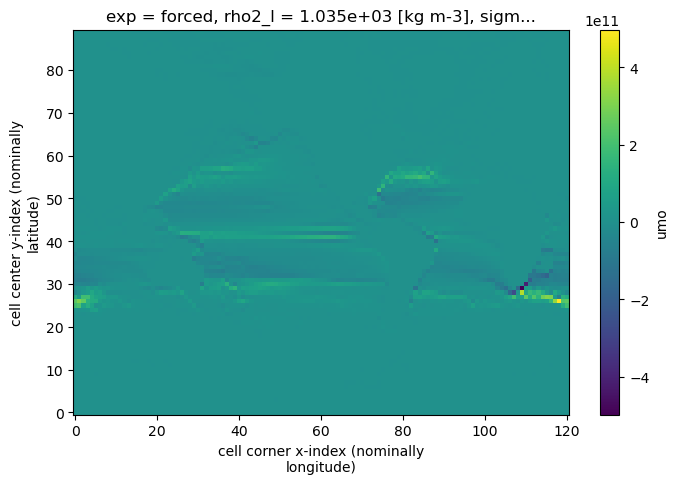

In [43]:
boundary_layer.umo.sum(dim='time').plot(cmap='viridis')

In [44]:
boundary_layer.umo.isel(time=0)[:,1:121:1].sigma2_l

<xarray.DataArray 'sigma2_l' ()> Size: 8B
array(35.17725)
Coordinates:
    exp              <U6 24B 'forced'
    rho2_l           float64 8B dask.array<chunksize=(), meta=np.ndarray>
    sigma2_l         float64 8B 35.18
    time             int64 8B 0
    time_since_init  int64 8B dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    axis:          Z
    cell_methods:  sigma2_l:point
    edges:         sigma2_i
    long_name:     Target Potential Density minus 1000 kg/m3 at cell center
    positive:      down
    units:         kg m-3

In [45]:
boundary_layer.umo.isel(time=0)[:,:]

<xarray.DataArray 'umo' (yh: 90, xq: 121)> Size: 44kB
dask.array<getitem, shape=(90, 121), dtype=float32, chunksize=(90, 121), chunktype=numpy.ndarray>
Coordinates:
    dyCu             (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    exp              <U6 24B 'forced'
    geolat_u         (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    geolon_u         (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    rho2_l           float64 8B dask.array<chunksize=(), meta=np.ndarray>
    sigma2_l         float64 8B 35.18
    time             int64 8B 0
    time_since_init  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    wet_u            (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * xq               (xq) int64 968B 0 1 2 3 4 5 6 ... 115 116 117 118 119 120
  * yh               (yh) int64 720B 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Attributes:
    cell_methods:   sigma2_l:sum yh:sum xq:point time:mean
    interp_method:  none
    long_name:      Ocean Mass X Transport
    standard_name:  ocean_mass_x_transport
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg s-1

In [46]:
both_boundary_layers = xr.concat([boundary_layer,sigma_BLplus1],dim='sigma2_l')

In [47]:
dropped_sigma = both_boundary_layers.drop_vars('sigma2_l')

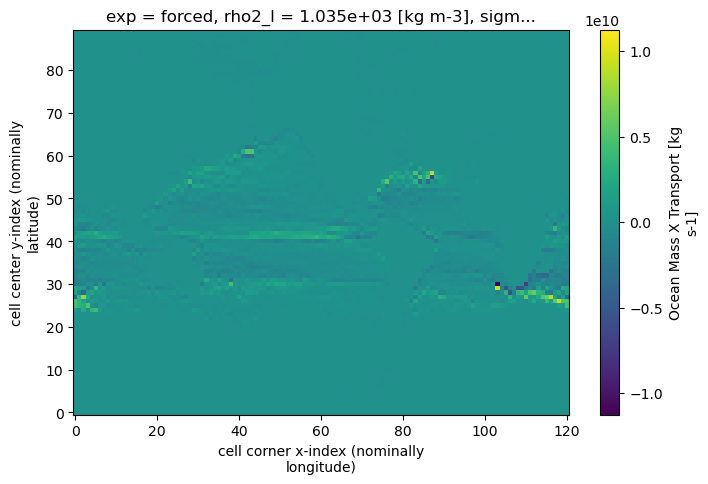

In [48]:
both_boundary_layers.umo.isel(time=0).isel(sigma2_l=0).plot(cmap='viridis')

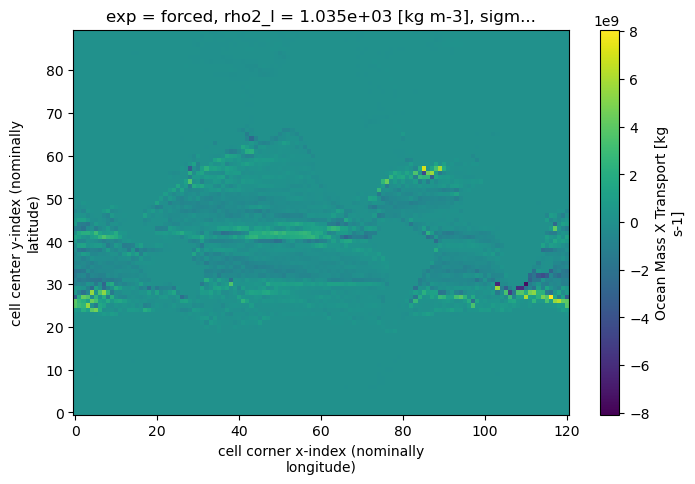

In [49]:
both_boundary_layers.umo.isel(time=0).isel(sigma2_l=1).plot(cmap='viridis')

In [50]:
len(np.unique(sigma_BLplus1.sigma2_bounds.isel(time_bounds=0)))

4346

In [51]:
***
BREAAAAAAAAAAAAK 

SyntaxError: invalid syntax (1074546346.py, line 1)

In [ ]:
print('max vvel is ' + str(converted_vvel.mean(dim='time').fillna(0.).values.max()) + 
      '\nmin vvel is' + str(converted_vvel.mean(dim='time').fillna(0.).values.min()))

In [ ]:
converted_vvel

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
m = watermass_converted_vvel.mean(dim='time').plot(add_colorbar=False)
fig.colorbar(m,ax=ax,label='vvel (m/s)')
ax.invert_yaxis()

In [ ]:
boundary.thkcello.isel(time=20,yh=20).sigma2_l[-2]

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
boundary.thkcello.isel(time=20,yh=20).plot()
ax.set_ylim(35,37.1)
ax.invert_yaxis()

In [ ]:
boundary.deptho.plot()

In [ ]:
boundary.thkcello

In [ ]:
# calculate the streamfunction
psi = converted_vvel * 

In [ ]:
watermass.sigma2_bounds.isel(exp=0).diff(dim='time_bounds')

In [ ]:
watermass.sigma2_bounds.isel(exp=0,yh=60).isel(time_bounds=30).plot()

In [ ]:
drho_dt = watermass.sigma2_bounds.isel(exp=0).diff(dim='time_bounds') / watermass.time_bounds.diff(dim='time')
drho_dt.isel(yh=50,xh=50).plot()

In [ ]:
# what's the max value of drho/dt
a = drho_dt.values
a[np.isnan(a)]=0
a.max()

In [ ]:
# IS THIS EVEN REASONABLE
# rho tendency is small and it gets even more negative suddenly when target potential density reaches like 37?? 
# honestly, i'd bet that there is a problem with the differencing

drho_dt.isel(time_bounds=30).isel(yh=45,xh=60).plot()

In [ ]:
BREAAAAAAAAAAAAAAAAAAAAAK

In [ ]:
watermass
# tendency term
# d rho / dt
drho = watermass.sigma2_bounds.diff(dim='time')
dt = watermass.time.diff(dim='time')

rho_tendency = drho/dt
rho_tendency.plot()

# is it wrong of me to just want to use the streamfunction calculation


In [ ]:
lam = 'sigma2'
default_bins = True

budgets_dict = xbudget.load_preset_budget(model='MOM6_3Donly')
# budgets_dict

In [ ]:
xbudget.collect_budgets(grid,budgets_dict)
simple_budget = xbudget.aggregate(budgets_dict)
#simple_budget

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        #region
    )
    wmb.mass_budget(lam, default_bins=default_bins)
    wmt = wmb.wmt
#    wmt.load()

In [ ]:
wmb.target_coords

In [ ]:
cm4x.sigma2_l.values

In [ ]:
cm4x.sigma2_i.values

In [ ]:
wmb.wmt.mass_tendency.isel(exp=0).isel(sigma2_l_target=0)

In [ ]:
dir(wmb.wmt)

In [ ]:
wmt.sigma2_l_target.values

In [ ]:
wmt

In [ ]:
# I'm just goiong to see how far I can get with the sigma2_bounds variable

# calculate normal vector


cm4x.isel(sigma2_l=2).isel(exp=0).

In [ ]:
cm4x.sigma2_l

In [ ]:
cm4x.sigma2_bounds.isel(exp=0)